## Contents of this notebook

Here we will explore the four methods of extracting the global spectrum of a flow (here atmospheric winds in the year 2020) using the software Flowsieve.

1. Extracting the spectrum from "coarse KE coarsened map"
2. Spectrum from "coarse KE area average"
3. From "ulon and ulat spectrum avg"
4. From "ulon and ulat spectrum coarsened map"
5. Overview, with how each method differs

## 1. Extracting the spectrum from "coarse KE coarsened map"

Coarse refers to the kinetic energy contained in scales greater than our filter scale. It is the result of locally averaging our u and v velocity fields and then calculating the resulting kinetic energy. "Coarsened map" refers to the fact we have put our results on a 2-degree by 2-degree grid instead of the native 12th-of-a-degree grid the calculations were performed on.

To calculate the spectrum from coarse KE (provided it has been calculated for more than one filtering scale), one can take the derivative with respect to the filtering scale. This tells us how much energy is added when we use a finer filtering kernel.

For consistency with Fourier methods, we will actually take the derivative with respect to the wavenumber, which is given by $k = 2\pi/l$ where l is in meters and k is in rad/m.

If we were to take the derivative with respect to $1/l$ which would also be valid, the magnitude of our results would deviate by $2\pi$ from Fourier method spectra.

In [12]:
from netCDF4 import Dataset
import numpy as np

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

accumulators = {
    'global': {
        'cKE_sum': 0,
        'cKE_count': 0
    }
}

In [15]:
for month in months:
    with Dataset(f'../IFSAnalysis/Data/{month}20012IFS_full.nc', 'r') as dset:
        ell = dset['ell'][0:19]                                       #filter length scales l "ell"
        cLat = dset['coarse_latitude'][:]                             #coarse latitude, 2 degree increments from -pi to pi, in radians used for weighting
        cKE = dset['coarse_KE_coarsened_map'][0:19, :, 0, :, :]       #coarse KE coarsened map, ell, time, level (0 as only 1 level), lat, lon

        cosine_weights = np.cos(cLat)                                 #relative weighting since on a lat lon grid boxes are of different sizes

        cKE_combined_weighted = cKE * cosine_weights[np.newaxis, np.newaxis, :,  np.newaxis]/ np.sum(cosine_weights)
        cKE_combined_sum = np.sum(cKE_combined_weighted, axis=(1,2,3))
        
        accumulators['global']['cKE_sum'] += cKE_combined_sum
        accumulators['global']['cKE_count'] += 16200 * np.shape(cKE)[1]

accumulators['global']['cKE_avg'] = accumulators['global']['cKE_sum']/accumulators['global']['cKE_count']

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from FiniteDiff import FiniteDiff 

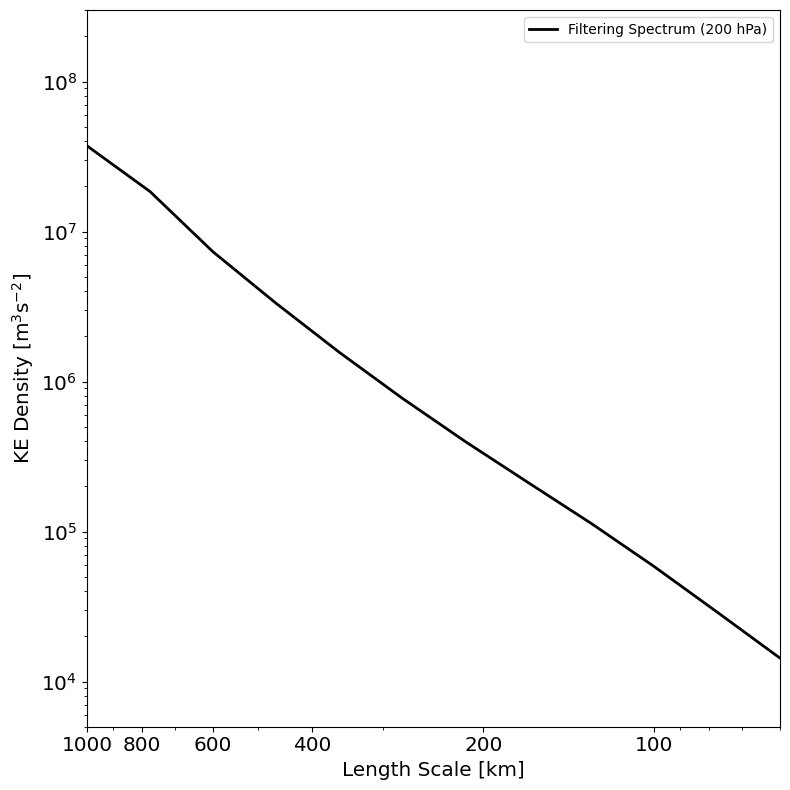

In [29]:
plt.figure(figsize=(8, 8))
with Dataset('../IFSAnalysis/Data/Jan20012IFS_full.nc', 'r') as dset:
    ell = dset['ell'][0:19]
    
ymin = 5e3
ymax = 3e8

filterWavenums = 2 * np.pi / np.array(ell[0:19])
FILTER_SCALES_km = np.array(ell[0:19]) / 1000

ddk_1D = FiniteDiff(2*np.pi/ell, 4, Sparse=True, Periodic=False, Uniform=False)

spec_avg_derivative_total = ddk_1D.dot(accumulators['global']['cKE_avg'])

plt.plot(FILTER_SCALES_km[5:], spec_avg_derivative_total[5:], color='black', label=f"Filtering Spectrum (cKE coarse map) (200 hPa)",linewidth=2)

plt.xscale('log')
plt.yscale('log')
min_scale, max_scale = FILTER_SCALES_km[7:].min(), FILTER_SCALES_km[5:19].max()
plt.xlim(max_scale, min_scale)
plt.ylim(ymin, ymax)

plt.xlabel('Length Scale [km]', fontsize='x-large')
plt.ylabel('KE Density [m$^3$s$^{-2}$]', fontsize='x-large')

x_ticks = [100, 200, 400, 600, 800, 1000]  
plt.xticks(x_ticks, labels=[str(x) for x in x_ticks], fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.grid(False)

plt.legend()
plt.show()

## 2. Spectrum from "Coarse KE area average"

Flowsieve also does the global averaging internally in different regions internally. It does this globally, in the tropics, south of the tropics, and north of the tropics. These are indexed 0, 1, 2, and 3, respectively.

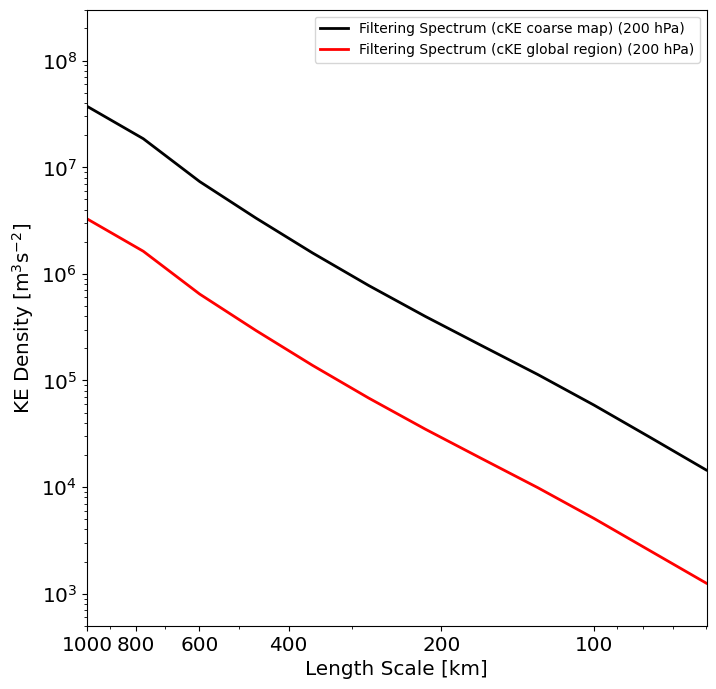

In [36]:
plt.figure(figsize=(8, 8))
with Dataset('../IFSAnalysis/Data/Jan20012IFS_full.nc', 'r') as dset:
    ell = dset['ell'][0:19]
    KEglobal = np.mean(dset['coarse_KE_area_average'][0:19,:,0,0],axis=1)   #dimensions are ell, time, depth, region

ddk_1D = FiniteDiff(2*np.pi/ell, 4, Sparse=True, Periodic=False, Uniform=False)
spec_avg_derivative_total_ckeg = ddk_1D.dot(KEglobal)

ymin = 5e2
ymax = 3e8

plt.plot(FILTER_SCALES_km[5:], spec_avg_derivative_total[5:], color='black', label=f"Filtering Spectrum (cKE coarse map) (200 hPa)",linewidth=2)

plt.loglog(FILTER_SCALES_km[5:], spec_avg_derivative_total_ckeg[5:]/1025, color='red', label=f"Filtering Spectrum (cKE global region) (200 hPa)",linewidth=2)

plt.xscale('log')
plt.yscale('log')
min_scale, max_scale = FILTER_SCALES_km[7:].min(), FILTER_SCALES_km[5:19].max()
plt.xlim(max_scale, min_scale)
plt.ylim(ymin, ymax)

plt.xlabel('Length Scale [km]', fontsize='x-large')
plt.ylabel('KE Density [m$^3$s$^{-2}$]', fontsize='x-large')

x_ticks = [100, 200, 400, 600, 800, 1000]  
plt.xticks(x_ticks, labels=[str(x) for x in x_ticks], fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.grid(False)

plt.legend()



What causes them to deviate?

First, let's see if the total KE sum on the coarsened map matches what we expect from the global data.

In [50]:
with Dataset('../IFSAnalysis/Data/Jan20012IFS_full.nc', 'r') as dset:
    ell = dset['ell'][0:19]
    KEglobal = dset['coarse_KE_area_average'][0:19,0,0,0]
    cKE = dset['coarse_KE_coarsened_map'][0:19, 0, 0, :, :] 

cKE_combined_weighted = cKE * cosine_weights[np.newaxis, :,  np.newaxis]/ np.sum(cosine_weights)

print("KE global " + format(KEglobal[-1],".2e"))
print("KE global from coarsened map " + format(np.mean(cKE[-1]),".2e"))
print("KE global from coarsened map weighted " + format(np.mean(cKE_combined_weighted[-1]),".2e"))

KE global 4.15e+05
KE global from coarsened map 3.51e+05
KE global from coarsened map weighted 4.63e+03
